In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
os.chdir("..")
from Source.Models.autoregBinned import AutoRegBinned
import Source.Util.preprocessing as prep
from Source.Util.util import load_params, get, get_device
import torch
from torch.utils.data import DataLoader

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
obs_names = np.array(["p_{T,l1}", "\phi_{l1}", "\eta_{l1}", "\mu_{l1}",
                    "p_{T,l2}", "\phi_{l2}", "\eta_{l2}", "\mu_{l2}",
                  "p_{T,j1}", "\phi_{j1}", "\eta_{j1}", "\mu_{j1}",
                  "p_{T,j2}", "\phi_{j2}", "\eta_{j2}", "\mu_{j2}"])

In [3]:
runpath = "runs/AutoRegBinned_local_5752/"
#runpath = "runs/set5_discr2_prep1/"
#runpath = "runs/set1_13dim_bin050_prep0_discr2/"
#runpath = "runs/set1_13dim_bin050_prep0_discr1/"
#runpath = "runs/set3_4dim_semiautoreg/"
#runpath = "runs/set3_13dim_semiautoreg_max/"

# Load data

In [4]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
params["device"]=get_device()

In [5]:
data_raw = np.load("../data/Z_2.npy")
data_raw = prep.preformat(data_raw, params)
n_bins = params["n_bins"]
channels = params["channels"]
data, data_mean, data_std, data_u, data_s, bin_edges, bin_means = prep.preprocess(data_raw, params=params)

# Initialize modified model class

In [6]:
model = AutoRegBinned(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)

Build model AutoRegBinned with n_head=3, n_per_head=12, n_blocks=3, intermediate_fac=2, n_bins=50


<All keys matched successfully>

In [7]:
data_split = params["data_split"]
n_data = len(data)
cut1 = int(n_data - data_split[0])
model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)

# Generate samples

In [8]:
n_samples = 10
samples, probs = model.sample_n_bonus(n_samples)
samples = samples[:,1:]
probs = probs[:,:,:-1]
data2 = data[:,1:] #cout out njets

print(samples)
print(np.shape(probs), np.shape(samples), np.shape(data))

[[46 26  7 17]
 [ 1 25 27 44]
 [19 34 45 38]
 [49 25 38  3]
 [19 36 49 48]
 [13 40 42  5]
 [37 24 16 38]
 [35 24 33 34]
 [17  9 13  0]
 [28 18 22 45]]
(10, 50, 4) (10, 4) torch.Size([1110181, 5])


In [9]:
def getEventsWithSameConditioning(data, condition):
    data_ret = data.copy()
    #print(data[:100,:], condition)
    for i in range(len(condition)):
        mask = np.where(condition[i] == data_ret[:,i])
        #print(mask, np.sum(mask))
        data_ret = data_ret[mask]
        print(np.shape(data_ret))
    return data_ret
for i in range(n_samples):
    print(getEventsWithSameConditioning(data2.numpy(), samples[i]))

(22202, 4)
(468, 4)
(10, 4)
(0, 4)
[]
(22202, 4)
(409, 4)
(3, 4)
(0, 4)
[]
(22203, 4)
(744, 4)
(17, 4)
(0, 4)
[]
(22203, 4)
(441, 4)
(4, 4)
(0, 4)
[]
(22203, 4)
(838, 4)
(17, 4)
(1, 4)
[[19 36 49 48]]
(22202, 4)
(448, 4)
(11, 4)
(0, 4)
[]
(22203, 4)
(548, 4)
(8, 4)
(0, 4)
[]
(22203, 4)
(655, 4)
(9, 4)
(1, 4)
[[35 24 33 34]]
(22203, 4)
(126, 4)
(2, 4)
(0, 4)
[]
(22202, 4)
(326, 4)
(8, 4)
(1, 4)
[[28 18 22 45]]


# Test plot

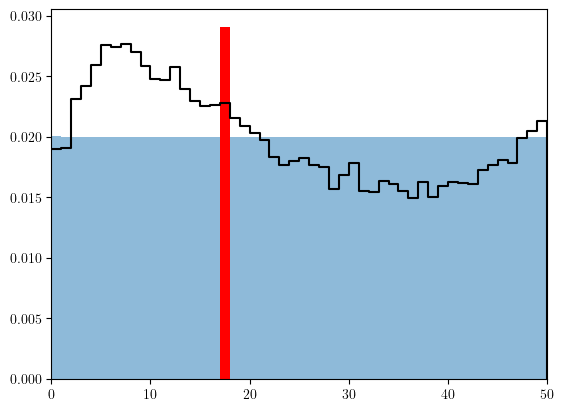

In [10]:
x=np.arange(n_bins+1)
idim=3
isample=0
ymax = 0.
plt.step(x, np.append(probs[isample,:,idim], [ymax]), where="post", color="k")
plt.hist(data2[:,idim], alpha=.5, density=True, range=[0,n_bins], bins=n_bins, align="mid", rwidth=1.)
ymin, ymax = plt.ylim()
plt.bar([samples[isample, idim]], [ymax], facecolor="r", width=1., align="edge")
plt.xlim(0,n_bins)
plt.show()

# Fancy plot

In [11]:
def probPlot(probs, samples, filenameOut=None, var=None, maxSamples=None):
    nsamples = np.shape(samples)[0]
    if(maxSamples!=None):
       nsamples = np.min([nsamples, maxSamples])
    ndim = np.shape(samples)[1]
    f, axarr = plt.subplots(nsamples, ndim, figsize=(3*ndim,3*nsamples), sharex=True,
                           gridspec_kw={"hspace": 0.})
    plt.tight_layout()
    
    x=np.arange(np.shape(probs)[1]+1)
    ymax=np.zeros(ndim)
    for isample in range(nsamples):
        print(f"Working on sample {isample}/{nsamples}")
        for idim in range(ndim):
            # need one more element in x and probs to make the plot nice
            axarr[isample,idim].step(x, np.append(probs[isample,:,idim], ymax[idim]), where="post", color="k")
            _, ymax0 = axarr[isample,idim].get_ylim()
            ymax[idim] = np.max([ymax[idim], ymax0])
            axarr[isample,idim].hist(data2[:,idim], density=True, alpha=.5, range=[0,np.shape(probs)[1]], rwidth=1., bins=np.shape(probs)[1], align="mid")
            axarr[isample,idim].set_xlim(0,np.shape(probs)[1])
            
            if((type(var) is np.ndarray) and isample==nsamples-1):
                axarr[isample,idim].set_xlabel(r"${%s}$ bin" %var[idim])
    for isample in range(nsamples):
        for idim in range(ndim):
            axarr[isample,idim].bar([samples[isample,idim]], [ymax[idim]], facecolor="r", width=1., align="edge")
            axarr[isample,idim].set_ylim(0, ymax[idim])
    if(filenameOut!=None):
        f.savefig(filenameOut, format="pdf")
    #plt.close()

Working on sample 0/5


KeyboardInterrupt: 

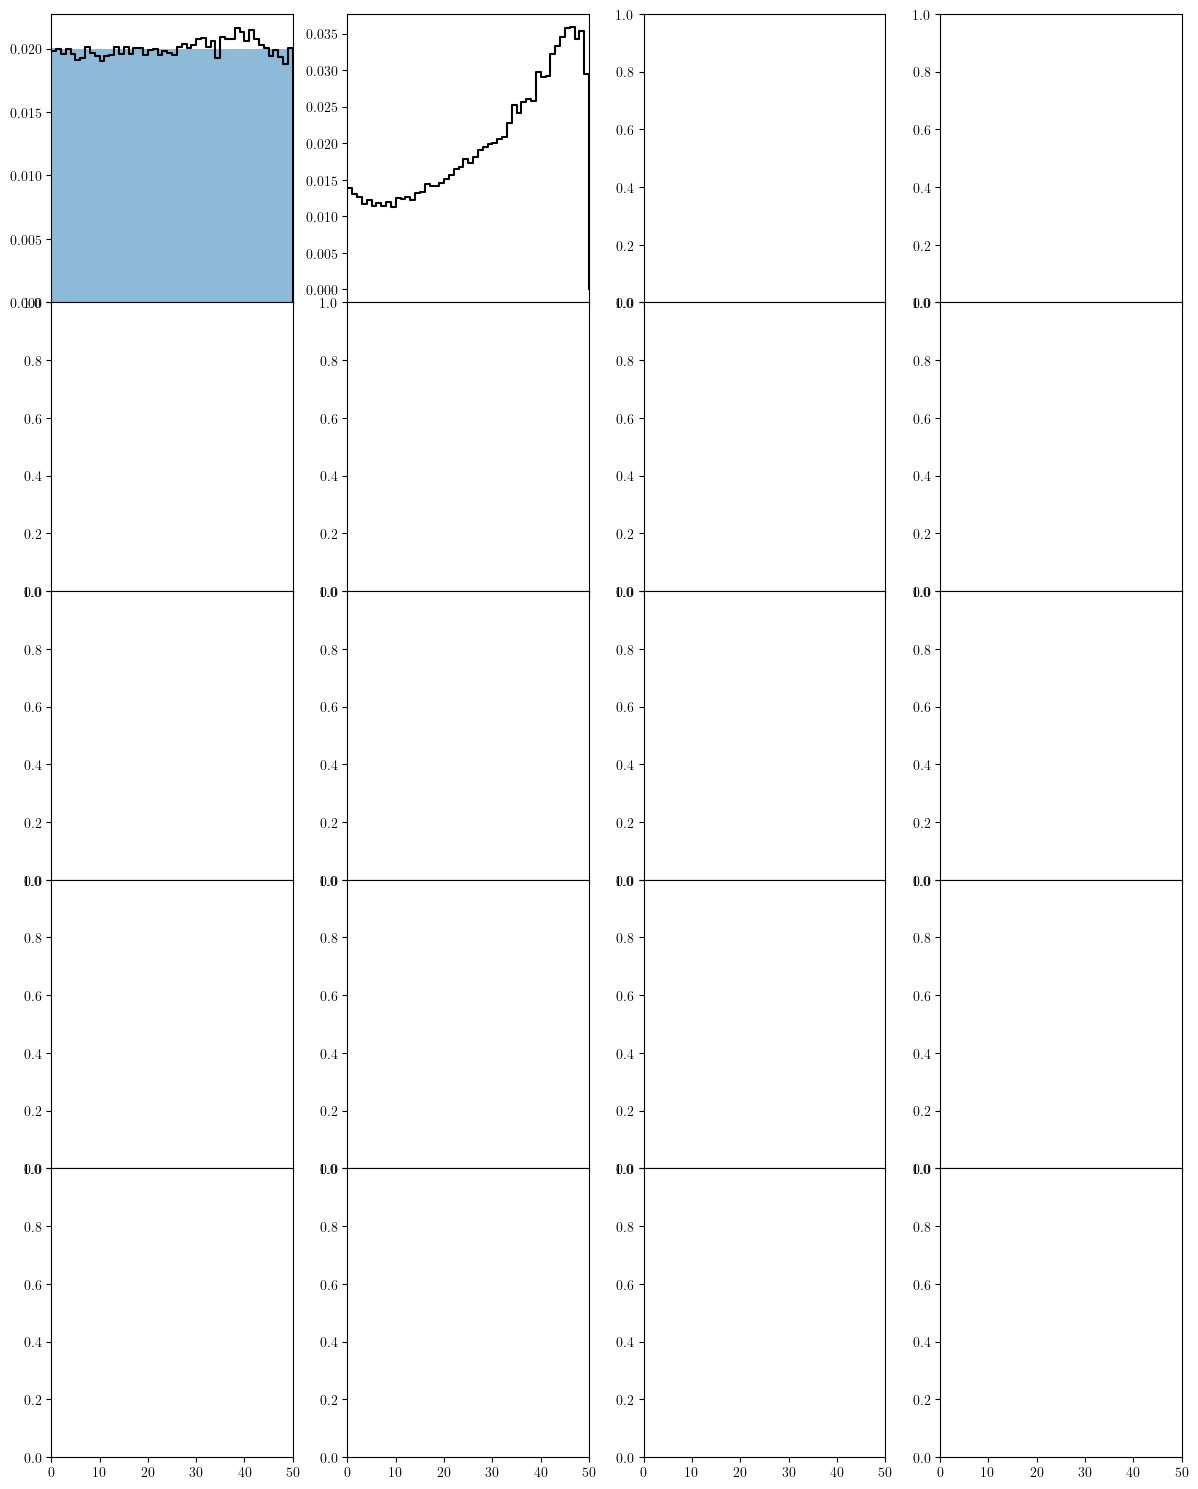

In [12]:
probPlot(probs, samples, var=obs_names[params["channels"]], maxSamples=5, 
         filenameOut="Scripts/visualizeAutoreg/visualizeAutoreg_13dim_discr1.pdf")